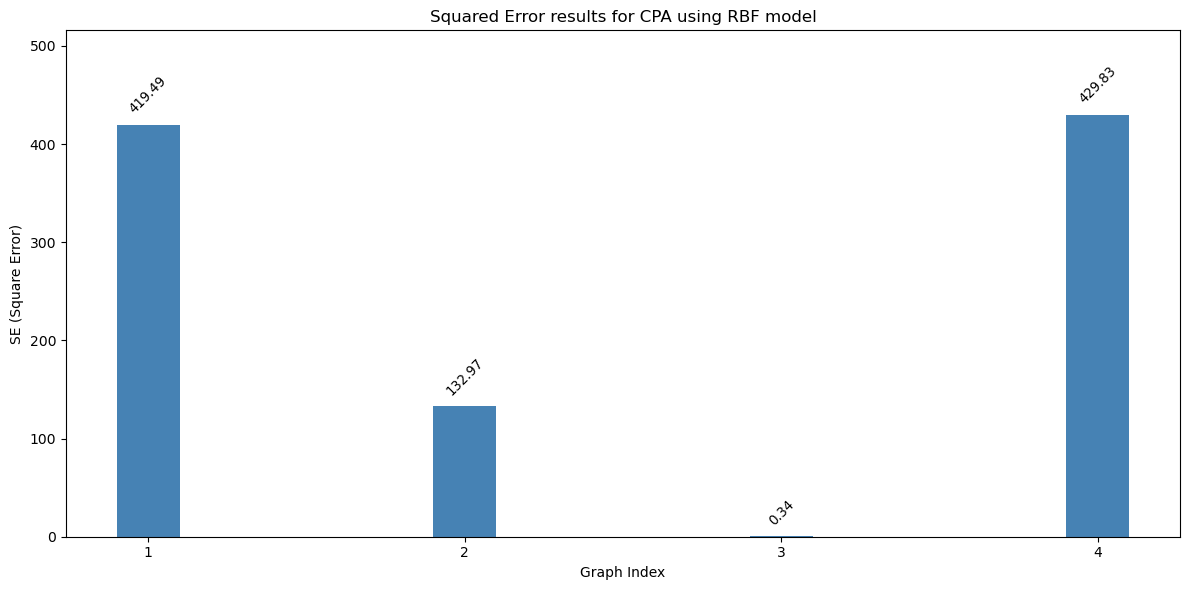

Mean Square Error (MSE) for Change Point Analysis using a RBF Model is: 245.66
R² for the RBF model: -1.25


Index,Data Tag,Pre-load,Changepoint Stress
1,TestNr1,2.00,22.48
2,testNr2,8.00,19.53
3,testNr3,12.00,11.42
4,testNr4,30.00,9.27


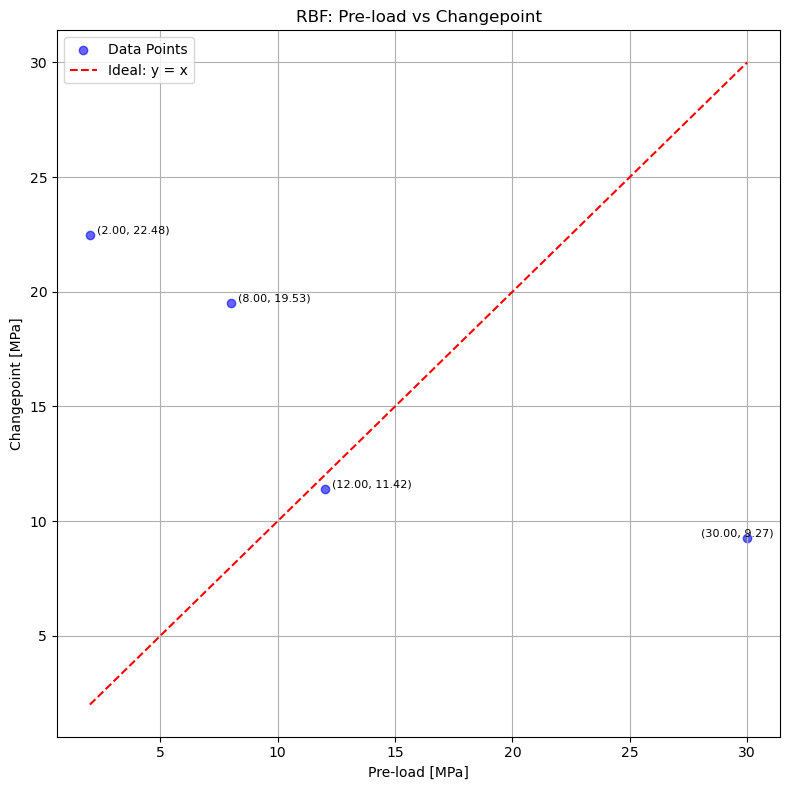

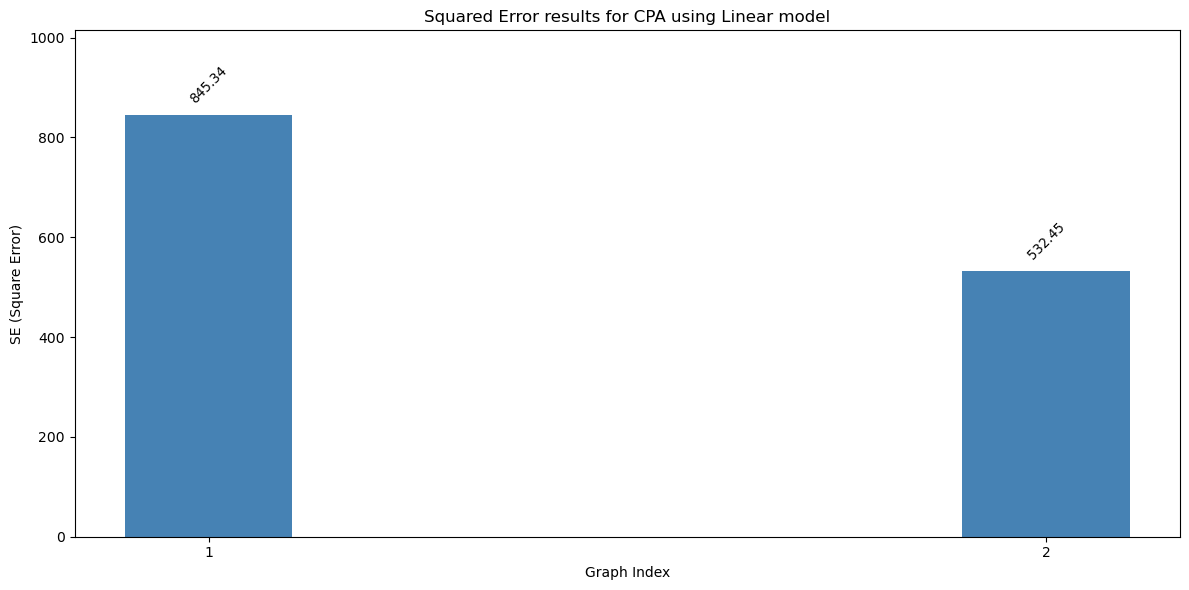

Mean Square Error (MSE) for Change Point Analysis Using a Linear Model is: 688.90
R² for the Linear model: -75.54


Index,Data Tag,Pre-load,Changepoint Stress
1,TestNr1,2.00,31.07
2,testNr2,8.00,31.07


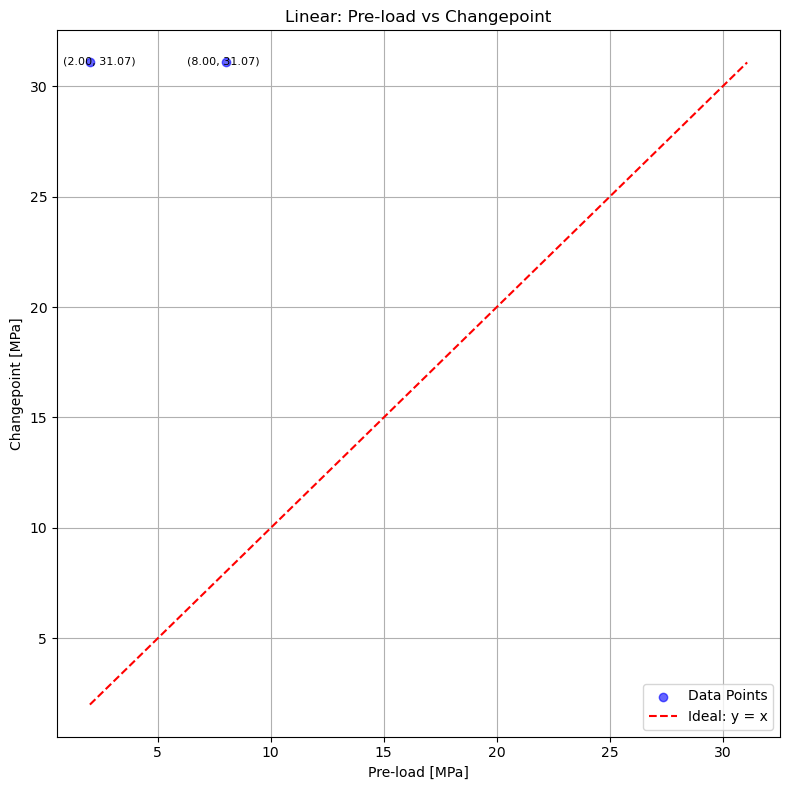

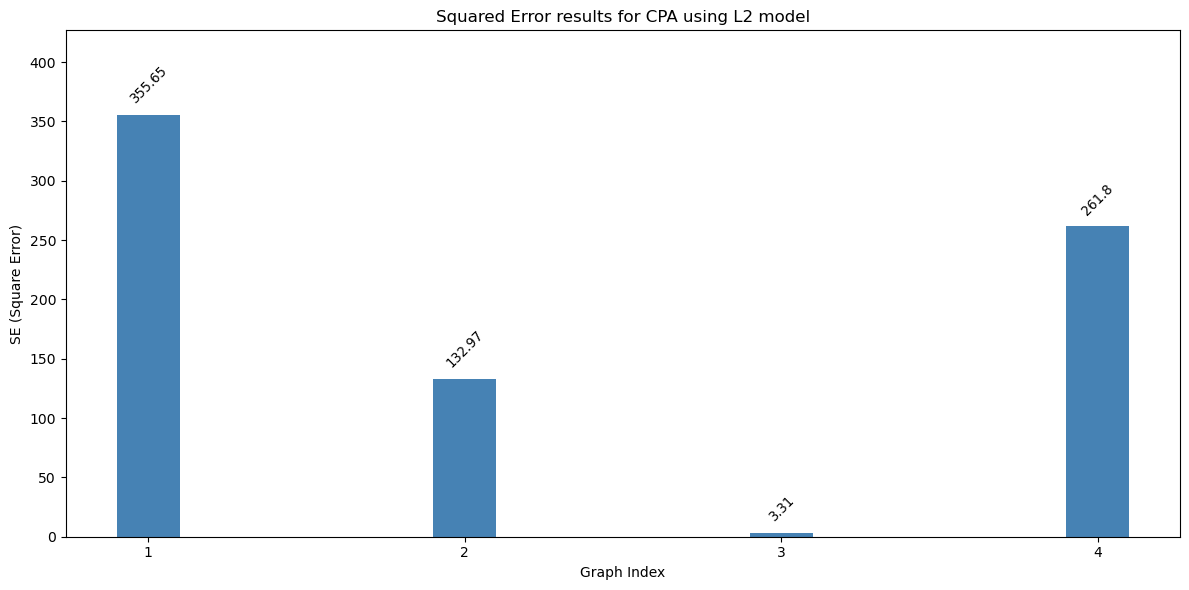

Mean Square Error (MSE) for Change Point Analysis Using a L2 Model is: 188.43
R² for the L2 model: -0.73


Index,Data Tag,Pre-load,Changepoint Stress
1,TestNr1,2.00,20.86
2,testNr2,8.00,19.53
3,testNr3,12.00,13.82
4,testNr4,30.00,13.82


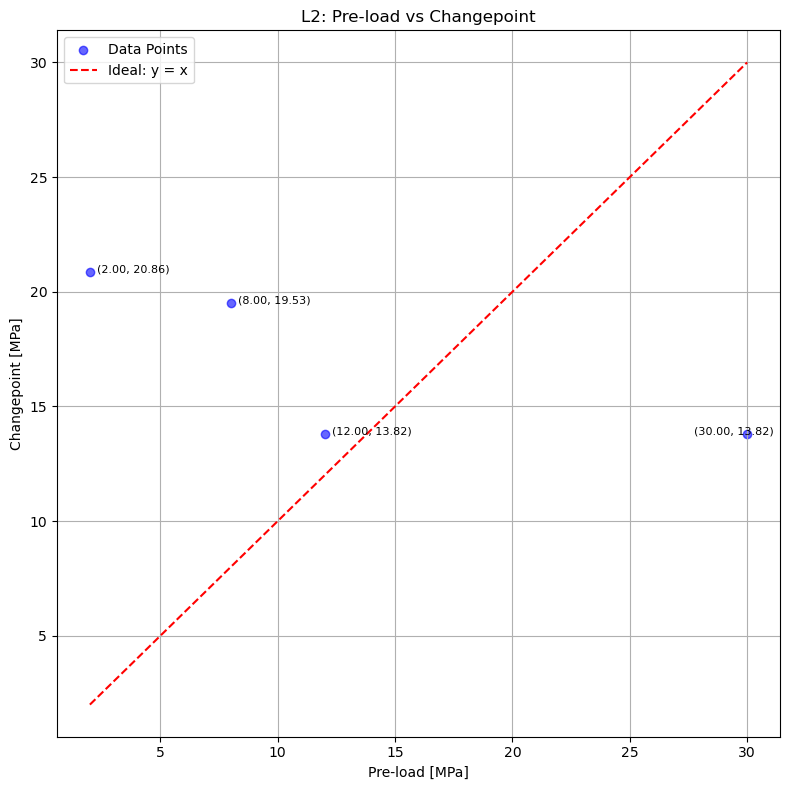

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text

# ----------------------------
# User-defined Configuration
# ----------------------------
filename = "cpaResultsExampleFilename"  # Do not include ".csv"

# ----------------------------
# Functions Used for Processing and Plotting CPA Results
# ----------------------------

def gather_data(file_name):
    """
    Gathers CPA data from a CSV file.
    
    Expected CSV Layout:
      dataTag,preLoad,rbfCP,linearCP,l2CP
    
    Returns:
      dataTags: List of the CSV 'dataTag' values.
      preLoads: List of the preLoad values (floats).
      rbfCPs: List of rbfCP values (floats).
      linearCPs: List of linearCP values (floats).
      l2CPs: List of l2CP values (floats).
    """
    # Function to check if the CSV file slot is empty
    def safe_float(val):
        try:
            return float(val)
        except (TypeError, ValueError):
            return np.nan

    dataTags = []
    preLoads = []
    rbfCPs = []
    linearCPs = []
    l2CPs = []

    # Reads and extracts data in the CSV file
    with open(file_name, "r", newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            dataTags.append(row.get("dataTag", ""))
            preLoads.append(safe_float(row.get("preLoad")))
            rbfCPs.append(safe_float(row.get("rbfCP")))
            linearCPs.append(safe_float(row.get("linearCP")))
            l2CPs.append(safe_float(row.get("l2CP")))

    return dataTags, preLoads, rbfCPs, linearCPs, l2CPs


def SE(preLoad, changepoint):
    """
    Compute the squared error between the pre-load and changepoint stress value.
    
    Parameters:
      preLoad : The pre-load value.
      changepoint : The changepoint stress value.
      
    Returns:
      Squared error.
    """
    return (preLoad - changepoint) ** 2


def graph_SE(SE_data, modeltype):
    """
    Plot a bar chart of SE values using the test index as the x-axis.
    
    Parameters:
      SE_data : List or array of SE values.
      modeltype : String indicating which model's SE is being plotted (e.g., 'RBF', 'Linear', or 'L2').
    """
    SE_data = np.array(SE_data, dtype=float)
    # Remove NaNs
    mask = ~np.isnan(SE_data)
    SE_data = SE_data[mask]
    if SE_data.size == 0:
        print(f"No data to plot for {modeltype} (all changepoints missing).")
        return
    
    # Create indices for each data point (starting at 1)
    indices = list(range(1, len(SE_data) + 1))
    plt.figure(figsize=(12, 6))
    
    # Plot bars with the x-axis given by these indices.
    bars = plt.bar(indices, SE_data, color='steelblue', width=0.2)
    
    # Set y-axis limits and determine a label offset.
    max_se = np.nanmax(SE_data)
    plt.ylim(0, max_se * 1.2)
    offset = max_se * 0.02
    
    # Annotate bars with their SE value.
    for bar in bars:
        yval = round(bar.get_height(), 2)
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + offset,
            f'{yval}',
            ha='center',
            va='bottom',
            rotation=45,
            fontsize=9.5
        )

    plt.xlabel('Graph Index')
    plt.ylabel('SE (Square Error)')
    plt.title(f'Squared Error results for CPA using {modeltype} model')
    plt.xticks(indices)
    plt.tight_layout()
    plt.show()
    
    return "plotting complete"


def create_table(data_tags, preLoad, changepoint, title="My Table Title"):
    """
    Creates a table with 4 columns: Index, Data Tag, pre-load, Changepoint stress.
    
    Parameters:
      data_tags: List of dataTag values.
      preLoad: List of the pre-load values.
      changepoint: List of the changepoint stress values.
      title: Title for the table (default "My Table Title").
    
    Returns:
      A styled pandas DataFrame displaying the table.
    """
    # Check that all input lists have the same length.
    if not (len(data_tags) == len(preLoad) == len(changepoint)):
        raise ValueError("All input lists must have the same length.")
    
    # Generate a list of indices (starting at 1)
    indices = list(range(1, len(data_tags) + 1))
    
    # Create a pandas DataFrame
    df = pd.DataFrame({
        "Index": indices,
        "Data Tag": data_tags,
        "Pre-load": preLoad,
        "Changepoint Stress": changepoint,
    })
    # Hide the default DataFrame index (0 to n-1) so only the custom "Index" column is displayed.
    styled = (
        df.style
          .hide(axis="index")
          .set_caption(title)
          .format({"Pre-load": "{:.2f}", "Changepoint Stress": "{:.2f}"})
    )
    return styled


def plot_preLoad_vs_changepoint(preLoad, changepoint, title="Pre-load vs Changepoint"):
    """
    Plots a scatter plot of pre-load stress vs changepoint stress and overlays a y=x line.
    
    Parameters:
      preLoad: List or array of pre-load stress values.
      changepoint: List or array of changepoint stress values.
      title: Title for the plot (default "Pre-load vs Changepoint").
    """
    
    preLoad = np.array(preLoad, dtype=float)
    changepoint = np.array(changepoint, dtype=float)
    # Remove NaNs
    mask = ~np.isnan(changepoint)
    preLoad = preLoad[mask]
    changepoint = changepoint[mask]
    if preLoad.size == 0:
        print(f"No data to plot for {title}.")
        return
    
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot
    plt.scatter(preLoad, changepoint, color='blue', alpha=0.6, label='Data Points')
    
    # Create and store text annotations.
    texts = []
    for p, c in zip(preLoad, changepoint):
        texts.append(plt.text(p, c, f'({p:.2f}, {c:.2f})', fontsize=8, ha='left', va='bottom'))
    
    # Adjust text to prevent overlapping.
    adjust_text(texts, verbose=0)
    
    # Determine min and max for plotting the ideal y=x line.
    min_val = min(preLoad.min(), changepoint.min())
    max_val = max(preLoad.max(), changepoint.max())
    
    # Plot the ideal y=x line.
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: y = x')
    
    # Add labels and title.
    plt.xlabel("Pre-load [MPa]")
    plt.ylabel("Changepoint [MPa]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return


def r2_metric(preLoad, changepoint):
    """
    Calculates the coefficient of determination, R².
    
    Parameters:
      preLoad: List or array of pre-load stress values.
      changepoint: List or array of changepoint stress values.
    
    Returns:
      R² value as a float.
      
    Formula:
      R² = 1 - (sum((preLoad - changepoint)^2) / sum((preLoad - mean(preLoad))^2))
    """
    preLoad = np.array(preLoad, dtype=float)
    changepoint = np.array(changepoint, dtype=float)
    
    # Remove NaNs
    mask = ~np.isnan(changepoint)
    preLoad = preLoad[mask]
    changepoint = changepoint[mask]
    
    ss_res = np.sum((preLoad - changepoint) ** 2)
    ss_tot = np.sum((preLoad - np.mean(preLoad)) ** 2)
    
    # Prevent division by zero if all pre-load values are the same.
    if ss_tot == 0:
        return 1.0
    return 1 - (ss_res / ss_tot)


# ----------------------------
# Running functions with user defined input
# ----------------------------
#  Gathering Data:
dataTag, preLoad, rbfCP, linearCP, l2CP = gather_data(f"{filename}.csv")

#  RBF analysis:
valid = [i for i, cp in enumerate(rbfCP) if not np.isnan(cp)]
if not valid:
    print("No RBF changepoints detected in any experiments.")
else:
    idx_tags = [dataTag[i] for i in valid]
    idx_pre  = [preLoad[i] for i in valid]
    idx_cp   = [rbfCP[i] for i in valid]

    # Computing and graphing the SE, comparing the changepoint from the RBF model and pre-load
    SE_rbf = SE(np.array(idx_cp), np.array(idx_pre))
    graph_SE(SE_rbf, "RBF")
    print(f"Mean Square Error (MSE) for Change Point Analysis using a RBF Model is: {np.nanmean(SE_rbf):.2f}")
    
    # Calculate and display the R² metric for the RBF model.
    print(f"R² for the RBF model: {r2_metric(idx_pre, idx_cp):.2f}")
    
    # Create a table showing the graph index, dataTag, pre-load, and changepoint stress.
    display(create_table(idx_tags, idx_pre, idx_cp, title="RBF: Pre-load vs. Changepoint"))
    
    # Plot the pre-load pre-load vs CPA RBF changepoint stress.
    plot_preLoad_vs_changepoint(idx_pre, idx_cp, title="RBF: Pre-load vs Changepoint")

#  Linear analysis:
valid = [i for i, cp in enumerate(linearCP) if not np.isnan(cp)]
if not valid:
    print("No Linear changepoints detected in any experiments.")
else:
    idx_tags = [dataTag[i] for i in valid]
    idx_pre  = [preLoad[i] for i in valid]
    idx_cp   = [linearCP[i] for i in valid]

    # Computing and graphing the SE, comparing the changepoint from the Linear model and pre-load
    SE_lin = SE(np.array(idx_cp), np.array(idx_pre))
    graph_SE(SE_lin, "Linear")
    print(f"Mean Square Error (MSE) for Change Point Analysis Using a Linear Model is: {np.nanmean(SE_lin):.2f}")
    
    # Calculate and display the R² metric for the Linear model.
    print(f"R² for the Linear model: {r2_metric(idx_pre, idx_cp):.2f}")
    
    # Create a table showing the graph index, dataTag, pre-load, and changepoint stress.
    display(create_table(idx_tags, idx_pre, idx_cp, title="Linear: Pre-load vs. Changepoint"))
    
    # Plot the pre-load vs CPA Linear changepoint stress.
    plot_preLoad_vs_changepoint(idx_pre, idx_cp, title="Linear: Pre-load vs Changepoint")

#  L2 analysis:
valid = [i for i, cp in enumerate(l2CP) if not np.isnan(cp)]
if not valid:
    print("No L2 changepoints detected in any experiments.")
else:
    idx_tags = [dataTag[i] for i in valid]
    idx_pre  = [preLoad[i] for i in valid]
    idx_cp   = [l2CP[i] for i in valid]

    # Computing and graphing the SE, comparing the changepoint from the L2 model and pre-load
    SE_l2 = SE(np.array(idx_cp), np.array(idx_pre))
    graph_SE(SE_l2, "L2")
    print(f"Mean Square Error (MSE) for Change Point Analysis Using a L2 Model is: {np.nanmean(SE_l2):.2f}")
    
    # Calculate and display the R² metric for the L2 model.
    print(f"R² for the L2 model: {r2_metric(idx_pre, idx_cp):.2f}")
    
    # Create a table showing the graph index, dataTag, pre-load, and changepoint stress.
    display(create_table(idx_tags, idx_pre, idx_cp, title="L2: Pre-load vs. Changepoint"))
    
    # Plot the pre-load vs CPA L2 changepoint stress.
    plot_preLoad_vs_changepoint(idx_pre, idx_cp, title="L2: Pre-load vs Changepoint")
